In [0]:
# Load libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn import metrics
import sys
from google.colab import drive

### Model performance metric ftn

In [0]:
def get_accuracy(probs, labels, accu_thre=0.5):
    pred_labels = np.zeros(probs.shape)
    pred_labels[probs >= accu_thre] = 1.0
    accuracy = metrics.accuracy_score(labels, pred_labels)
    return accuracy

def get_ks_statistics(probs, labels):
    probs_pos = probs[labels == 1]
    probs_neg = probs[labels == 0]
    ks, ks_p_value = stats.ks_2samp(probs_pos, probs_neg)
    return ks, ks_p_value

def get_auc_ar(probs, labels):
    auc = metrics.roc_auc_score(labels, probs)
    ar = auc * 2 - 1
    return auc, ar

class Performances:
    def __init__(self, probs, labels, accu_thre=0.5):
        accuracy = get_accuracy(probs, labels, accu_thre=accu_thre)
        ks, ks_p_value = get_ks_statistics(probs, labels)
        auc, ar = get_auc_ar(probs, labels)
        self.accuracy = accuracy
        self.ks = ks * 100  # percent
        self.ks_p_value = ks_p_value
        self.auc = auc * 100  # percent
        self.ar = ar * 100  # percent

### Data load : raw datset

In [0]:
# 구글 드라이브 접근 권한 획득
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Set paths
data_rootpath = r'/content/gdrive/My Drive/ML_basic/ML_basic_dataset/model_data'

# Read data
X_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_raw_full_X.csv'))
X_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_raw_full_X.csv'))
X_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_raw_full_X.csv'))

# X_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_raw_X.csv'))
# X_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_raw_X.csv'))
# X_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_raw_X.csv'))

y_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_y.csv'))
y_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_y.csv'))
y_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_y.csv'))

NameError: ignored

In [0]:
X_train_df.head()

bc_util  annual_inc  ...    dti  mo_sin_rcnt_tl
Unnamed: 0                       ...                       
930            30.0    100000.0  ...  10.60             0.0
1104           42.4     50000.0  ...  11.43            12.0
1224            2.5     45000.0  ...  14.47             1.0
1875           58.6     50000.0  ...  18.70            12.0
2787            0.0     40000.0  ...   8.07             7.0

[5 rows x 14 columns]

In [0]:
X_train_df.shape

(117736, 14)

In [0]:
# index 설정
def set_index_and_sort(df):
    df.set_index('Unnamed: 0', inplace=True, drop=True, verify_integrity=True)
    df.sort_index(inplace=True)
    return df

In [0]:
X_train_df = set_index_and_sort(X_train_df)
X_valid_df = set_index_and_sort(X_valid_df)
X_test_df = set_index_and_sort(X_test_df)

KeyError: ignored

In [0]:
y_train_df = set_index_and_sort(y_train_df)
y_valid_df = set_index_and_sort(y_valid_df)
y_test_df = set_index_and_sort(y_test_df)

KeyError: ignored

In [0]:
# 컬럼 타입 확인
dtypes_df = X_train_df.dtypes
cate_cols = dtypes_df[dtypes_df=='object'].index.tolist()
num_cols = dtypes_df[dtypes_df!='object'].index.tolist()

In [0]:
cate_cols

['home_ownership']

In [0]:
num_cols

['bc_util',
 'annual_inc',
 'mths_since_recent_bc',
 'mths_since_rcnt_il',
 'acc_open_past_24mths',
 'num_actv_rev_tl',
 'bc_open_to_buy',
 'all_util',
 'tot_hi_cred_lim',
 'mo_sin_old_rev_tl_op',
 'inq_last_6mths',
 'dti',
 'mo_sin_rcnt_tl']

### numeric variable -> standardization!!

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
X_train_numbers = X_train_df.drop(cate_cols, axis=1)
X_valid_numbers = X_valid_df.drop(cate_cols, axis=1)
X_test_numbers = X_test_df.drop(cate_cols, axis=1)

# Normalization / column-naming
scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_numbers), columns=X_train_numbers.columns, dtype=np.float64)
X_valid_norm = pd.DataFrame(scaler.transform(X_valid_numbers), columns=X_valid_numbers.columns, dtype=np.float64)
X_test_norm = pd.DataFrame(scaler.transform(X_test_numbers), columns=X_test_numbers.columns, dtype=np.float64)

In [0]:
X_train_norm.index=X_train_df.index
X_valid_norm.index=X_valid_df.index
X_test_norm.index=X_test_df.index

In [0]:
X_train_df.head()

bc_util  annual_inc  ...    dti  mo_sin_rcnt_tl
Unnamed: 0                       ...                       
930            30.0    100000.0  ...  10.60             0.0
1104           42.4     50000.0  ...  11.43            12.0
1224            2.5     45000.0  ...  14.47             1.0
1875           58.6     50000.0  ...  18.70            12.0
2787            0.0     40000.0  ...   8.07             7.0

[5 rows x 14 columns]

In [0]:
X_train_norm.head()

bc_util  annual_inc  ...       dti  mo_sin_rcnt_tl
Unnamed: 0                        ...                          
930        -0.894865    0.237934  ... -0.896027       -0.882545
1104       -0.481069   -0.323378  ... -0.797201        0.456634
1224       -1.812559   -0.379509  ... -0.435236       -0.770947
1875        0.059536   -0.323378  ...  0.068418        0.456634
2787       -1.895986   -0.435640  ... -1.197267       -0.101357

[5 rows x 13 columns]

### categorical variable -> ont-hod encoding!!

In [0]:
X_train_category = pd.get_dummies(X_train_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)
X_valid_category = pd.get_dummies(X_valid_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)
X_test_category = pd.get_dummies(X_test_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)

# Categorical dataset : 1 or -1
X_train_category = X_train_category * 2 - 1
X_valid_category = X_valid_category * 2 - 1
X_test_category = X_test_category * 2 - 1

### numeric X + categorical X

In [0]:
# Concatenate data frames
X_train_df = pd.merge(X_train_norm, X_train_category, left_index=True, right_index=True, how='inner')
X_valid_df = pd.merge(X_valid_norm, X_valid_category, left_index=True, right_index=True, how='inner')
X_test_df = pd.merge(X_test_norm, X_test_category, left_index=True, right_index=True, how='inner')

In [0]:
print(X_train_df.shape)
print(X_valid_df.shape)
print(X_test_df.shape)

(117736, 19)
(39245, 18)
(39246, 19)


## Modeling

tenserflow와 keras를 이용해봅시다.

In [0]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

In [0]:
import tensorflow as tf
tf.__version__
tf.test.gpu_device_name()

''

## Hyper parameters

임의의 hyper parameter를 설정합니다.

In [0]:
hidden_units = [200, 100]
l2_lambda = 0.002
learning_rate = 0.0001
epochs = 20
batch_size = 256

## Optimization

optimizer로는 adam을 씁니다.

In [0]:
adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

## Build Network

층(layer)을 생성해봅시다. 정상/불량 이렇게 두 가지 class만 있으니 activation으로 sigmoid를 이용합니다. multi class라면 softmax를 쓰세요.

In [0]:
model = Sequential()

model.add(Dense(hidden_units[0], 
         input_dim=X_train_df.shape[1],
         kernel_regularizer=l2(l2_lambda),
         kernel_initializer='glorot_normal')) # Xavier initialization

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(hidden_units[1], 
         kernel_regularizer=l2(l2_lambda),
         kernel_initializer='glorot_normal')) # Xavier initialization

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, 
                kernel_initializer='glorot_normal')) # Xavier initialization)
model.add(Activation('sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# For a binary classification problem
model.compile(optimizer=adam,
              loss='binary_crossentropy',
#               metrics=['acc']
             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from datetime import datetime
s1 = datetime.now()

hist = model.fit(X_train_df, y_train_df, 
                 epochs=epochs, 
                 batch_size=batch_size,
                 validation_data=(X_test_df, y_test_df))

s2 = datetime.now()
print((s2-s1).total_seconds())

Train on 117736 samples, validate on 39246 samples
Epoch 1/20
117736/117736 [==============================] - 3s 29us/sample - loss: 0.4153 - val_loss: 0.4136
Epoch 2/20
117736/117736 [==============================] - 3s 29us/sample - loss: 0.4142 - val_loss: 0.4117
Epoch 3/20
117736/117736 [==============================] - 3s 28us/sample - loss: 0.4116 - val_loss: 0.4108
Epoch 4/20
117736/117736 [==============================] - 3s 28us/sample - loss: 0.4106 - val_loss: 0.4101
Epoch 5/20
117736/117736 [==============================] - 3s 28us/sample - loss: 0.4088 - val_loss: 0.4078
Epoch 6/20
117736/117736 [==============================] - 3s 29us/sample - loss: 0.4083 - val_loss: 0.4080
Epoch 7/20
117736/117736 [==============================] - 3s 28us/sample - loss: 0.4069 - val_loss: 0.4059
Epoch 8/20
117736/117736 [==============================] - 3s 29us/sample - loss: 0.4055 - val_loss: 0.4049
Epoch 9/20
117736/117736 [==============================] - 3s 28us/sample - 

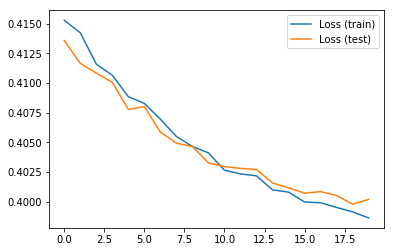

In [0]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(('Loss (train)', 'Loss (test)'), loc='upper right')
plt.show()

In [0]:
# Predict probability
prob_tr = model.predict_proba(X_train_df)
# prob_valid = model.predict_proba(X_valid_df)
prob_test= model.predict_proba(X_test_df)

In [0]:
# reshape
prob_tr = prob_tr.reshape(1, -1)[0]
# prob_valid = prob_valid.reshape(1, -1)[0]
prob_test = prob_test.reshape(1, -1)[0]

In [0]:
# Compute KS/AR
result_train = Performances(prob_tr, y_train_df['Y'])
# result_valid = Performances(prob_valid, y_valid_df['Y'])
result_test = Performances(prob_test, y_test_df['Y'])

In [0]:
print("Training KS : {:.5f}, / AR : {:.5f}".format(result_train.ks, result_train.ar))
# print("Validation KS : {:.5f}, / AR : {:.5f}".format(result_valid.ks, result_valid.ar))
print("Test KS : {:.5f}, / AR : {:.5f}".format(result_test.ks, result_test.ar))

Training KS : 25.58803, / AR : 35.43535
Test KS : 22.38308, / AR : 31.77226


In [0]:
# KS plotting ftn
def KS_compute_with_plot(prob, y_df):

    GOOD_p = prob[y_df['Y'] == 0]
    BAD_p = prob[y_df['Y'] == 1]

    ks = stats.ks_2samp(GOOD_p, BAD_p)

    ecdf_0 = sm.distributions.ECDF(GOOD_p)
    ecdf_1 = sm.distributions.ECDF(BAD_p)
    plt.plot(ecdf_0.x, ecdf_0.y, label="GOOD")
    plt.plot(ecdf_1.x, ecdf_1.y, label='BAD')
    # plt.xlim(0, 0.3)

    plt.ylabel('CDF')
    plt.xlabel('p')
    plt.title('KS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    return (ks[0])

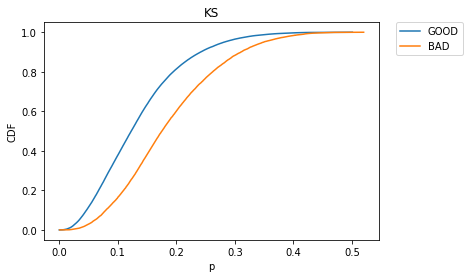

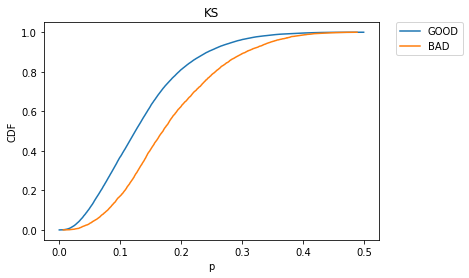

0.22383080490054408

In [0]:
# KS plotting
KS_compute_with_plot(prob=prob_tr, y_df=y_train_df)
# KS_compute_with_plot(prob=prob_valid, y_df=y_valid_df)
KS_compute_with_plot(prob=prob_test, y_df=y_test_df)

## Random search

### Hyper parameters

In [0]:
hidden_units = [200, 100]
l2_lambda = 0.002
learning_rate = 0.0001
epochs = 100
batch_size = 256